# DAnalyticsSS21 - EDA - Jan Burger

## 1. Imports

In [35]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from datetime import datetime
from dataprep.eda import create_report
from plotly.subplots import make_subplots
from utils import convert_weekdays_to_avg_no2_values_16, convert_weekdays_to_avg_no2_values_20

## 2. Reading the data

In [36]:
# Read files
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train_labels = pd.read_csv("train_labels.csv")

In [37]:
# Add label to train dataframe
df_train["no2"] = df_train_labels["no2"]

## 3. Feature creation
From the datetime feature many more features like year, month, day etc. can be extracted. These features will be used for further analysis.

In [38]:
# Convert date string into datetime object
df_train['dt_utc'] = pd.to_datetime(df_train['dt_utc'])

In [39]:
# Creating basic features from date

# year
df_train["year"] = df_train["dt_utc"].apply(lambda x: x.year)
# month
df_train["month"] = df_train["dt_utc"].apply(lambda x: x.month)
# day
df_train["day"] = df_train["dt_utc"].apply(lambda x: x.day)
# hour
df_train["hour"] = df_train["dt_utc"].apply(lambda x: x.hour)
# weekday
df_train["weekday"] = df_train["dt_utc"].apply(lambda x: x.weekday())
# weeknumber
df_train["weeknumber"] = df_train["dt_utc"].apply(lambda x: x.isocalendar()[1])
# date
df_train["date"] = df_train["dt_utc"].apply(lambda x: x.date())

In [40]:
# Creating advanced featuers from date

# workday / weekend
df_train["is_workday"] = df_train["weekday"].apply(lambda x: 1 if x < 5 else 0)
# quarter
def get_quarter(month):
    if month < 4:
        return 1
    if month > 3 and month < 7:
        return 2
    if month > 6 and month < 10:
        return 3
    if month > 9:
        return 4

df_train["quarter"] = df_train["month"].apply(get_quarter)

## 4. Split Dataset by Crossing
Due to major differences in no2 values and generel differences the data will be splitted between sensorids. Crossing A7 has sensorid 16 and A81 has sensorid 20.

In [41]:
# Splitting up dataframe by sensor_id due to major differences in values

# A7  -> Sensor_ID = 16
# A81 -> Sensor_ID = 20

df_train_sensor_id_20 = df_train[df_train["sensor_id"] == 20]
df_train_sensor_id_16 = df_train[df_train["sensor_id"] == 16]

In [42]:
# Dropping columns which consist only of null values
df_train_sensor_id_20.drop(df_train_sensor_id_20.columns[6:14], axis=1, inplace=True)
df_train_sensor_id_16.drop(df_train_sensor_id_16.columns[24:42], axis=1, inplace=True)

## 5. Create new Feature: 12 o`clock values from the current date
No2 values are heavily influenced by previous no2 values of the same day. Therefore a new feature will be the no2 value from 12 o`clock for each day because this is the closest time for the predictions of the hours 17 & 18.

In [43]:
# preparing index for later merge operations in order to distinguish between test and train data --> index test data += 100000
df_train_sensor_id_20["index"] = df_train_sensor_id_20.index
df_train_sensor_id_16["index"] = df_train_sensor_id_16.index

In [44]:
df_train_sensor_id_20_hour_12 = df_train_sensor_id_20[df_train_sensor_id_20["hour"] == 12]

df_train_sensor_id_20 = pd.merge(df_train_sensor_id_20, df_train_sensor_id_20_hour_12[["date", "no2"]], how="left", on=["date"])

In [45]:
df_train_sensor_id_20.index = df_train_sensor_id_20["index"]
df_train_sensor_id_20.rename(columns={"no2_y": "12_o_clock_no2", "no2_x": "no2"}, inplace = True)
df_train_sensor_id_20.drop(columns=["index"], inplace = True)


In [46]:
df_train_sensor_id_16_hour_12 = df_train_sensor_id_16[df_train_sensor_id_16["hour"] == 12]

df_train_sensor_id_16 = pd.merge(df_train_sensor_id_16, df_train_sensor_id_16_hour_12[["date", "no2"]], how="left", on=["date"])

In [47]:
df_train_sensor_id_16.index = df_train_sensor_id_16["index"]
df_train_sensor_id_16.rename(columns={"no2_y": "12_o_clock_no2", "no2_x": "no2"}, inplace = True)
df_train_sensor_id_16.drop(columns=["index"], inplace = True)


## 6. Basic EDA Report
The library dataprep automatically generates an EDA Report where things like the distribution of each feature, basic measures of central tendency, missing values and correlation can be seen. This gives a first broad overview of the dataset.

**Note:** Running this cell may take a few minutes

In [48]:
create_report(df_train_sensor_id_20).show_browser()
create_report(df_train_sensor_id_16).show_browser()

  0%|                                                                                         | 0/9656 [00:00<…

  0%|                                                                                         | 0/7048 [00:00<…

## 7. Grouping operations for further analysis

In [49]:
# Different groupby operations as a preparation for further analysis

# Group by day of month
df_train_sensor_id_20_group_by_day_of_month = df_train_sensor_id_20.groupby(["day"]).mean()
df_train_sensor_id_16_group_by_day_of_month = df_train_sensor_id_16.groupby(["day"]).mean()

# Group by weekday
df_train_sensor_id_20_group_by_weekday = df_train_sensor_id_20.groupby(["weekday"]).mean()
df_train_sensor_id_16_group_by_weekday = df_train_sensor_id_16.groupby(["weekday"]).mean()

# Group by weeknumber
df_train_sensor_id_20_group_by_weeknumber = df_train_sensor_id_20.groupby(["weeknumber"]).mean()
df_train_sensor_id_16_group_by_weeknumber = df_train_sensor_id_16.groupby(["weeknumber"]).mean()

# Group by month of year
df_train_sensor_id_20_group_by_month_of_year = df_train_sensor_id_20.groupby(["month"]).mean()
df_train_sensor_id_16_group_by_month_of_year = df_train_sensor_id_16.groupby(["month"]).mean()

# Group by hour of day
df_train_sensor_id_20_group_by_hour_of_day = df_train_sensor_id_20.groupby(["hour"]).mean()
df_train_sensor_id_16_group_by_hour_of_day = df_train_sensor_id_16.groupby(["hour"]).mean()

## 8. Analysis of missing values
Only December 2019 has missing values for weather columns. These columns are all mean or sum values from the whole day, therefore no differenciation between hours has to be made. Missing values can be replaced with the average value for the month. In this case only for december since we only have missing values in december.

**Note:** Missing no2 values at the end of the dataset occures because this is the test data with no given no2 values.

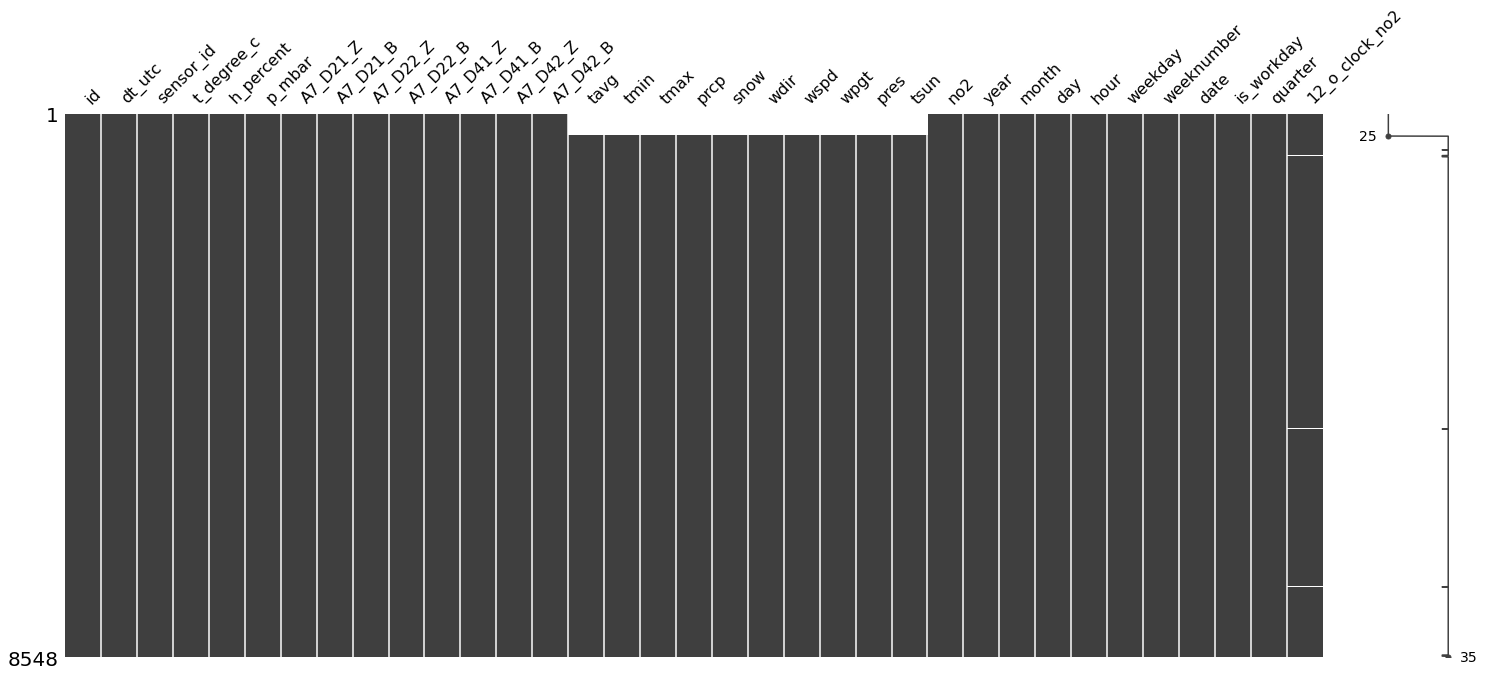

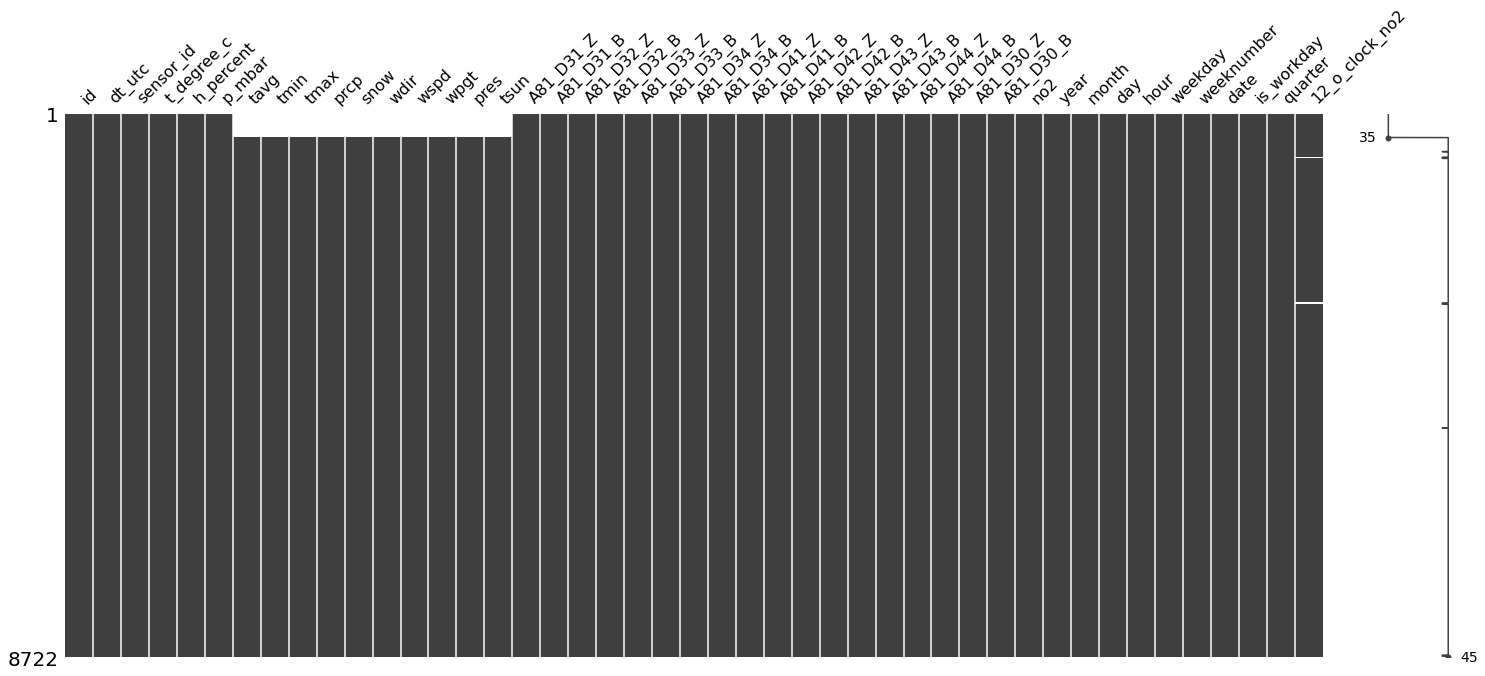

In [50]:
msno.matrix(df_train_sensor_id_16)
msno.matrix(df_train_sensor_id_20)

## 9. Analysis of different timeseries aspects

### 9.1 Average no2 values by weeknumber
In this chart we can see the average no2 values for each weeknumber in the year form 0 to 52. It can be clearly seen that no2 values for both crossings are higher in the summer weeks with a very high peak for crossing A81 during week 32. We can also see a very strong correlation between the crossing in terms of no2 values.

C:\Users\User\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




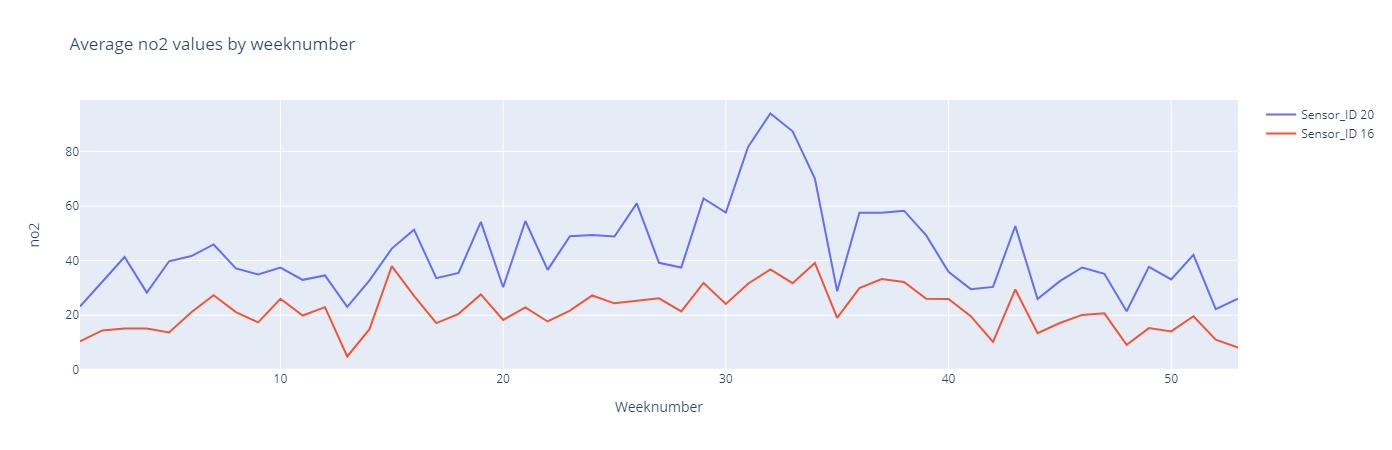

In [51]:
fig = go.Figure(
    layout=dict(title=dict(text="Average no2 values by weeknumber")),
    data=[
    go.Line(name='Sensor_ID 20', x=df_train_sensor_id_20_group_by_weeknumber.index, y=df_train_sensor_id_20_group_by_weeknumber["no2"]),
    go.Line(name='Sensor_ID 16', x=df_train_sensor_id_16_group_by_weeknumber.index, y=df_train_sensor_id_16_group_by_weeknumber["no2"]),
])
# Change the bar mode & set axis titles
fig.update_layout(barmode='group',  xaxis_title="Weeknumber",
    yaxis_title="no2")
fig.show()

### 9.2 Average no2 values by month
To get a clearer picture of the seasonal behaviour of no2 values in the next chart the average no2 values for each month in a year are listed. We can clearly see the peak during summer time.

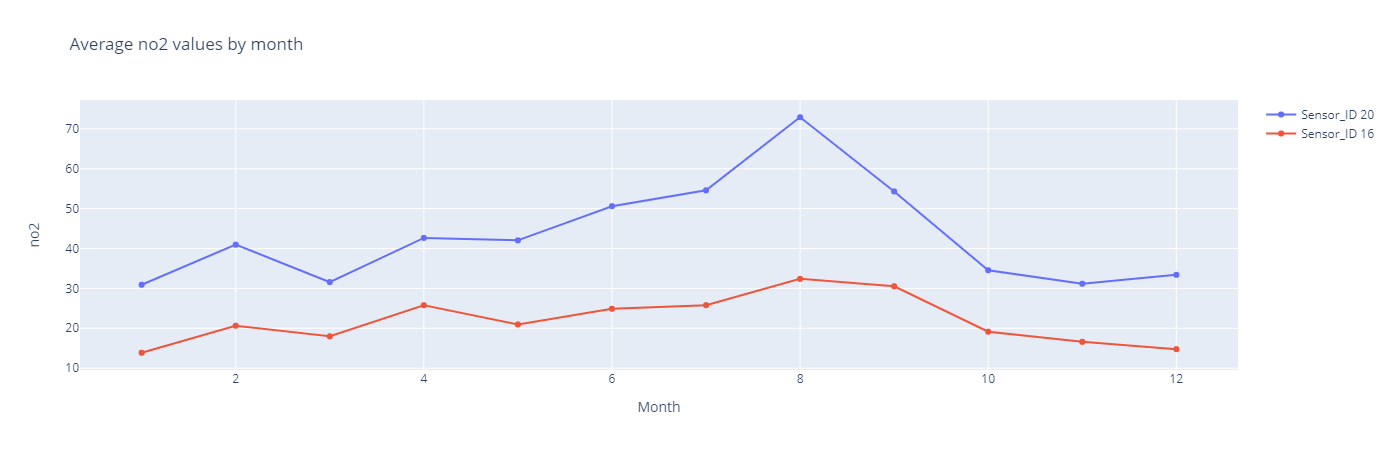

In [52]:
fig = go.Figure(
    layout=dict(title=dict(text="Average no2 values by month",)),
    data=[
    go.Line(name='Sensor_ID 20', x=df_train_sensor_id_20_group_by_month_of_year.index, y=df_train_sensor_id_20_group_by_month_of_year["no2"]),
    go.Line(name='Sensor_ID 16', x=df_train_sensor_id_16_group_by_month_of_year.index, y=df_train_sensor_id_16_group_by_month_of_year["no2"])
])
# Change the bar mode
fig.update_layout(barmode='group',  xaxis_title="Month",
    yaxis_title="no2")
fig.show()

### 9.3 Average no2 values by weekday
This analysis clearly shows that no2 values on the weekend are much lower compared to workdays. The only logical reason for this is the amount of traffic the differes between workdays and the weekend.

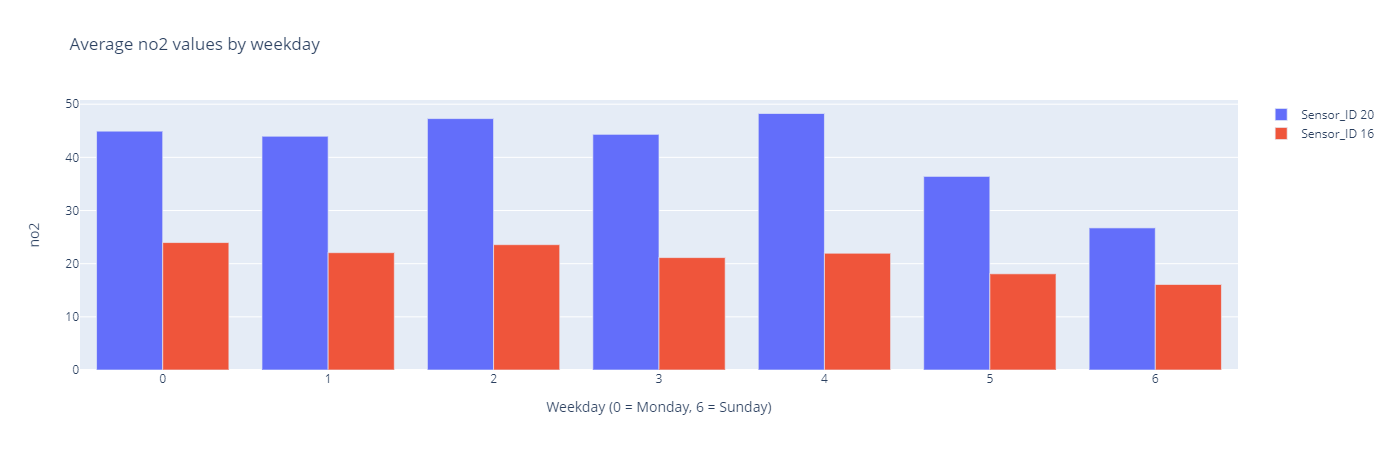

In [53]:
fig = go.Figure(
    layout=dict(title=dict(text="Average no2 values by weekday",)),
    data=[
    go.Bar(name='Sensor_ID 20', x=df_train_sensor_id_20_group_by_weekday.index, y=df_train_sensor_id_20_group_by_weekday["no2"]),
    go.Bar(name='Sensor_ID 16', x=df_train_sensor_id_16_group_by_weekday.index, y=df_train_sensor_id_16_group_by_weekday["no2"])
])
# Change the bar mode
fig.update_layout(barmode='group', xaxis_title="Weekday (0 = Monday, 6 = Sunday)",
    yaxis_title="no2")
fig.show()

### 9.4 Average no2 values by day of month
Day of month has no influence in the no2 values, which makes sense since there is no feature that is influenced by the day of a given month.

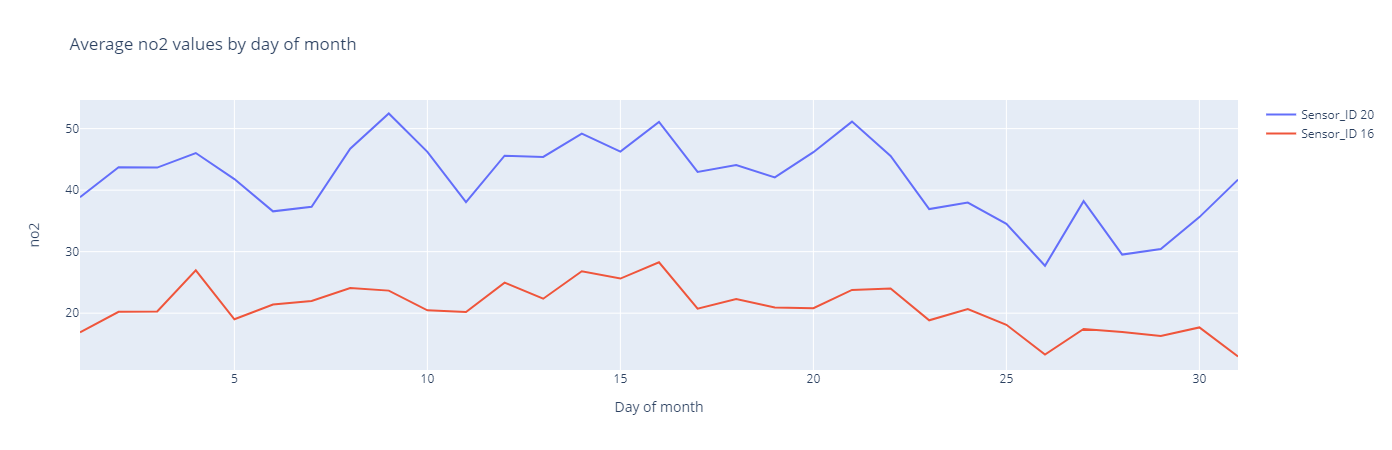

In [54]:
fig = go.Figure(
    layout=dict(title=dict(text="Average no2 values by day of month",)),
    data=[
    go.Line(name='Sensor_ID 20', x=df_train_sensor_id_20_group_by_day_of_month.index, y=df_train_sensor_id_20_group_by_day_of_month["no2"]),
    go.Line(name='Sensor_ID 16', x=df_train_sensor_id_16_group_by_day_of_month.index, y=df_train_sensor_id_16_group_by_day_of_month["no2"])
])
# Change the bar mode
fig.update_layout(barmode='group', xaxis_title="Day of month",
    yaxis_title="no2")
fig.show()

### 9.5 Average no2 values by hour of day
The interesting thing to see from this plot is that the average no2 values for crossing A81 seems to have only one large peak around 4pm meanwhile crossing A7 has two smaller peaks around 7am and 5-6pm.

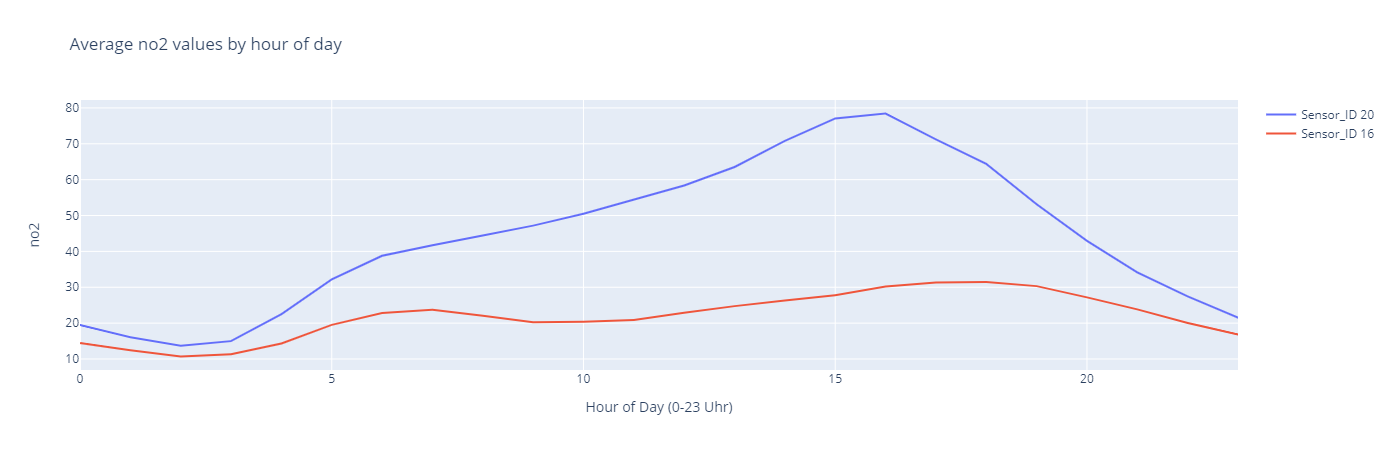

In [55]:
fig = go.Figure(
    layout=dict(title=dict(text="Average no2 values by hour of day",)),
    data=[
    go.Line(name='Sensor_ID 20', x=df_train_sensor_id_20_group_by_hour_of_day.index, y=df_train_sensor_id_20_group_by_hour_of_day["no2"]),
    go.Line(name='Sensor_ID 16', x=df_train_sensor_id_16_group_by_hour_of_day.index, y=df_train_sensor_id_16_group_by_hour_of_day["no2"])
])
# Change the bar mode
fig.update_layout(barmode='group', xaxis_title="Hour of Day (0-23 Uhr)",
    yaxis_title="no2")
fig.show()

### 9.6 Timeseries of no2 values
From these charts we can clearly see the start of the first corona lockdown bach in march 2020. What is also noticeable is the time during and shortly after christmas. We can see a clear decrease of no2 values during that time. 

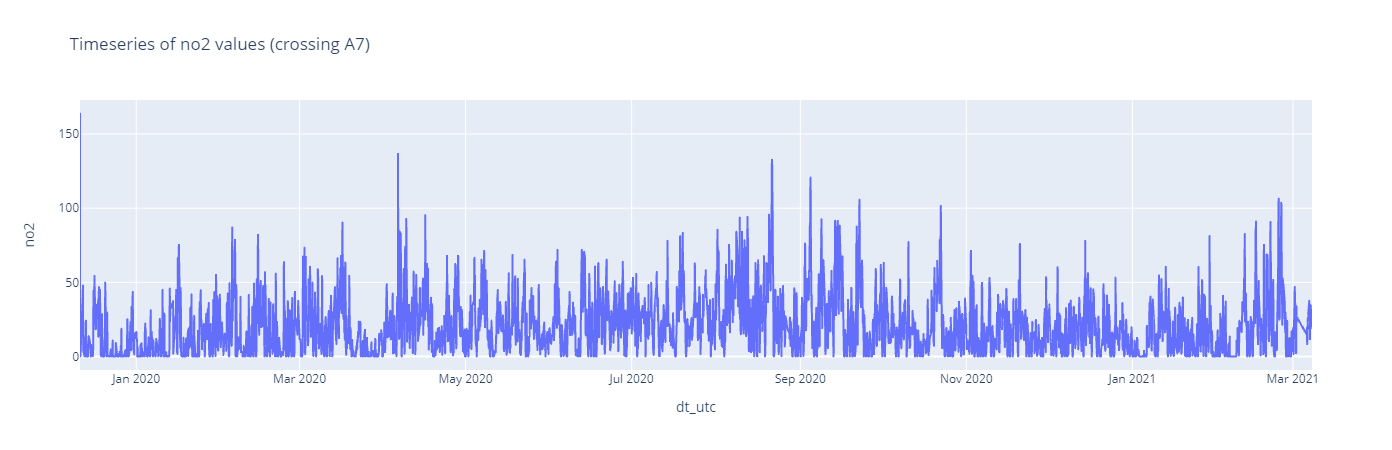

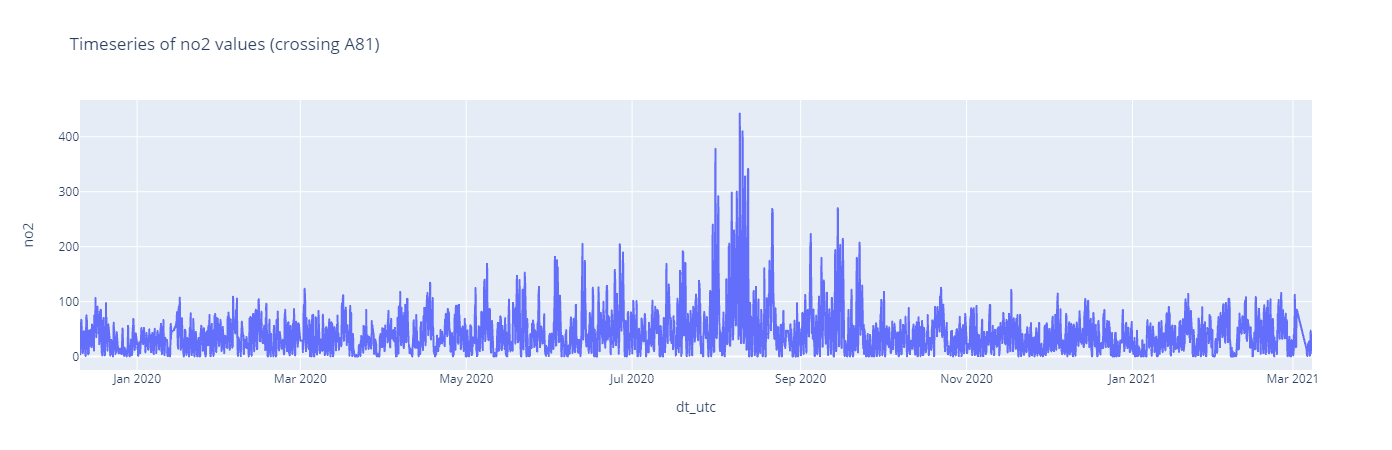

In [56]:
fig = px.line(df_train_sensor_id_16, x="dt_utc", y="no2", title="Timeseries of no2 values (crossing A7)")
fig.show()
fig = px.line(df_train_sensor_id_20, x="dt_utc", y="no2", title="Timeseries of no2 values (crossing A81)")
fig.show()

## 10. Correlation analysis between features
We can see a very high correlation between all traffic sensors which means during model building and feature selection the traffic sensors can be reduced to one or to an average value over all of them. There is also a high correlation bewtween some of the weather related fetures like ``t_degree_c`` and ``h_percent`` which intuitively makes sense. Therefore weather featuers should be picked carefully and collinearity should always be considered bewtween the weather features during features selection. All other featuers seem to be fairly independen of each other.

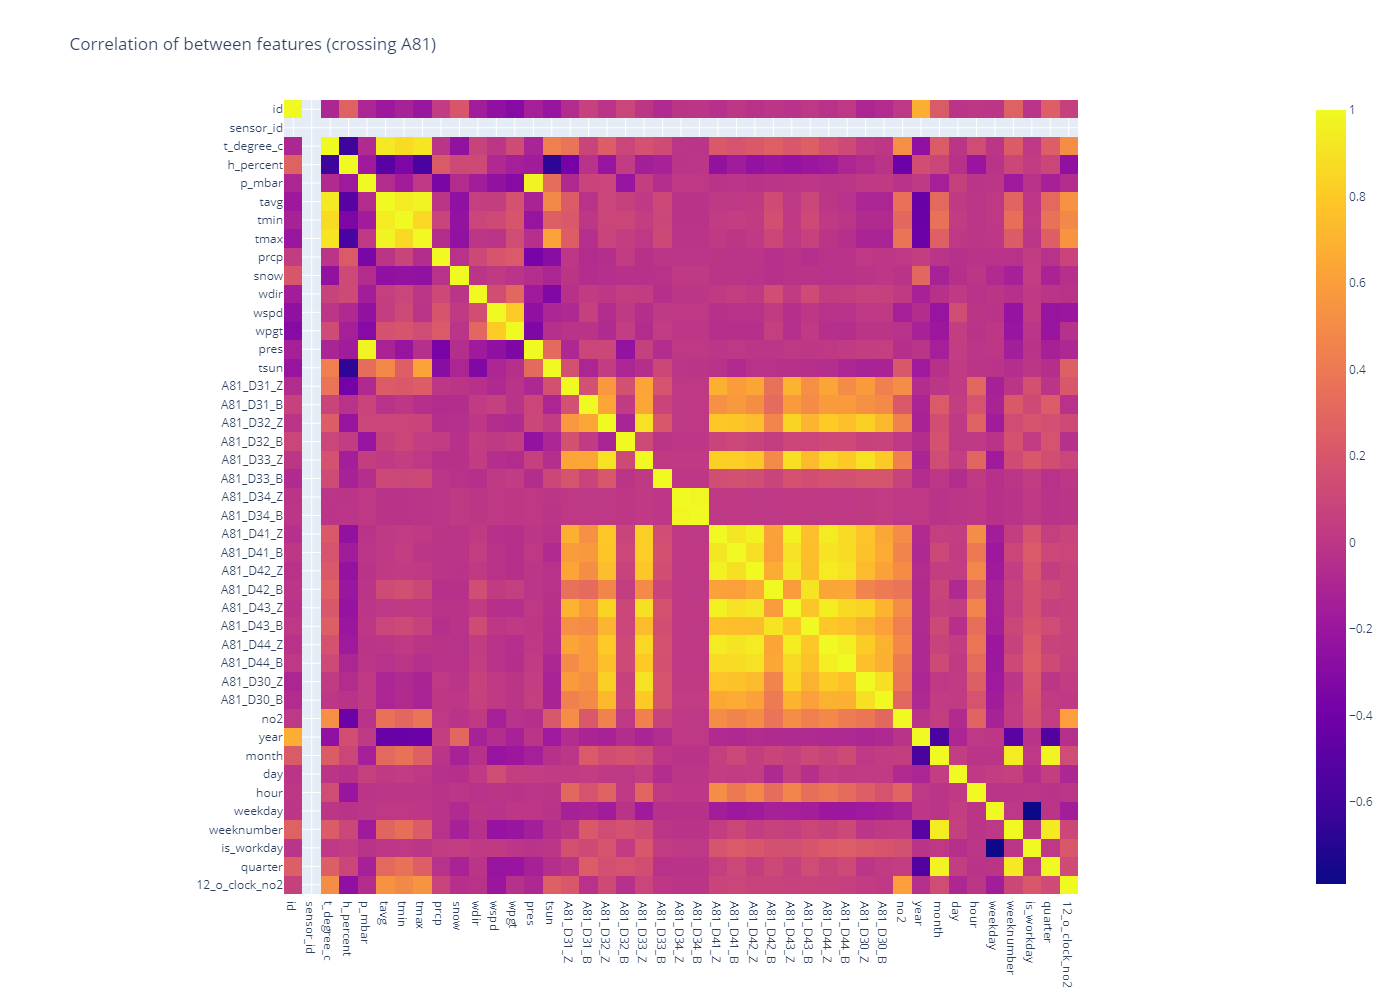

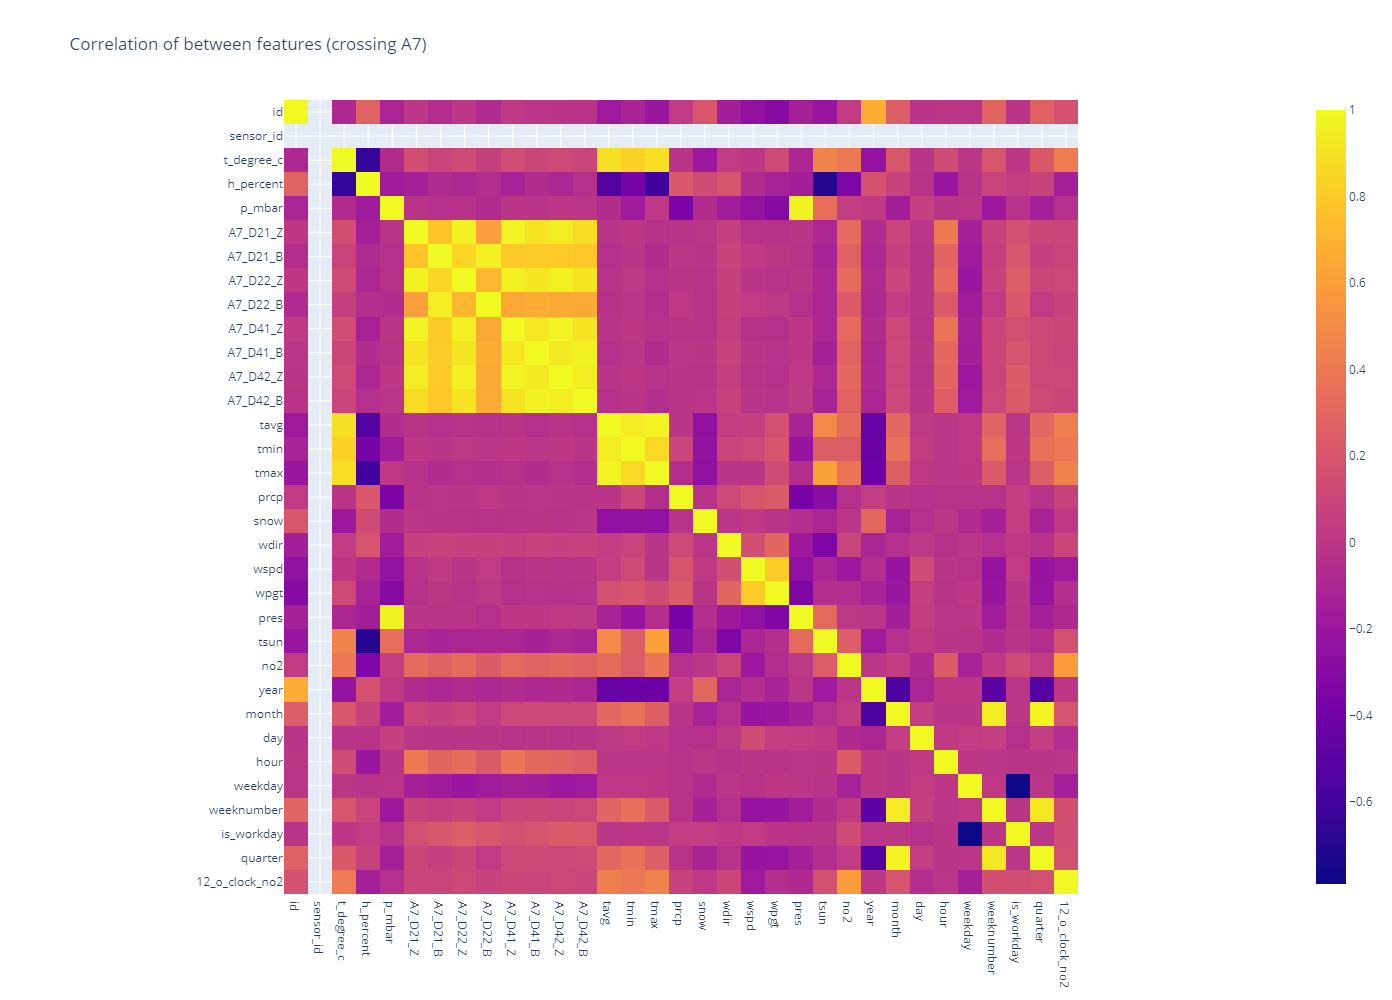

In [57]:
fig = px.imshow(df_train_sensor_id_20.corr(), width = 1300, height= 1000, title="Correlation of between features (crossing A81)")
fig.show()
fig = px.imshow(df_train_sensor_id_16.corr(), width = 1300, height= 1000, title="Correlation of between features (crossing A7)")
fig.show()

## 11. Outlier detection
There are some clearly unrealistic outliers regarding the temperature. These could either be delted or replaced with average values for the respective month

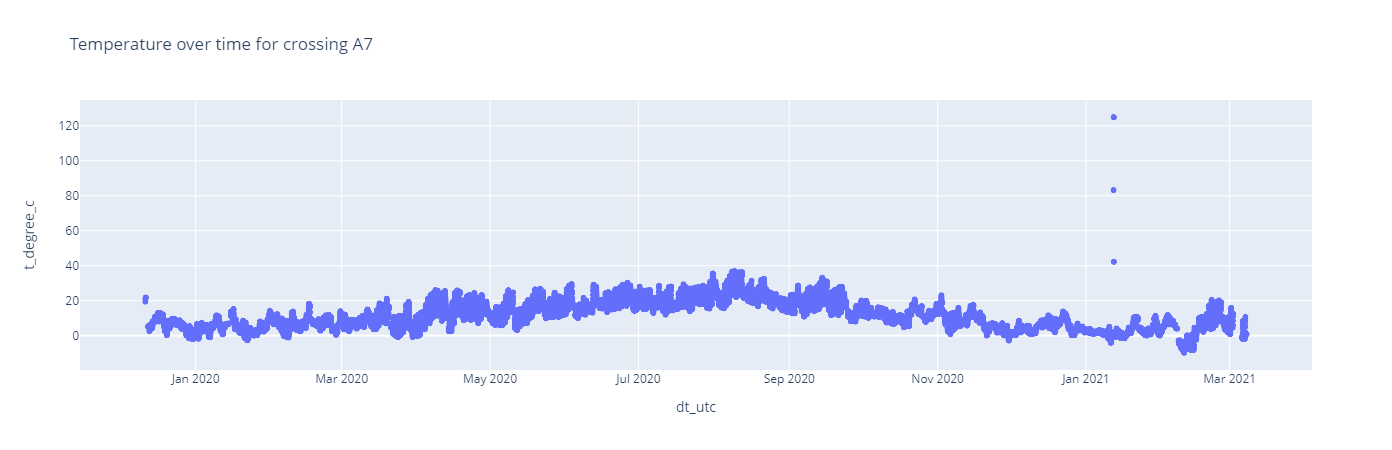

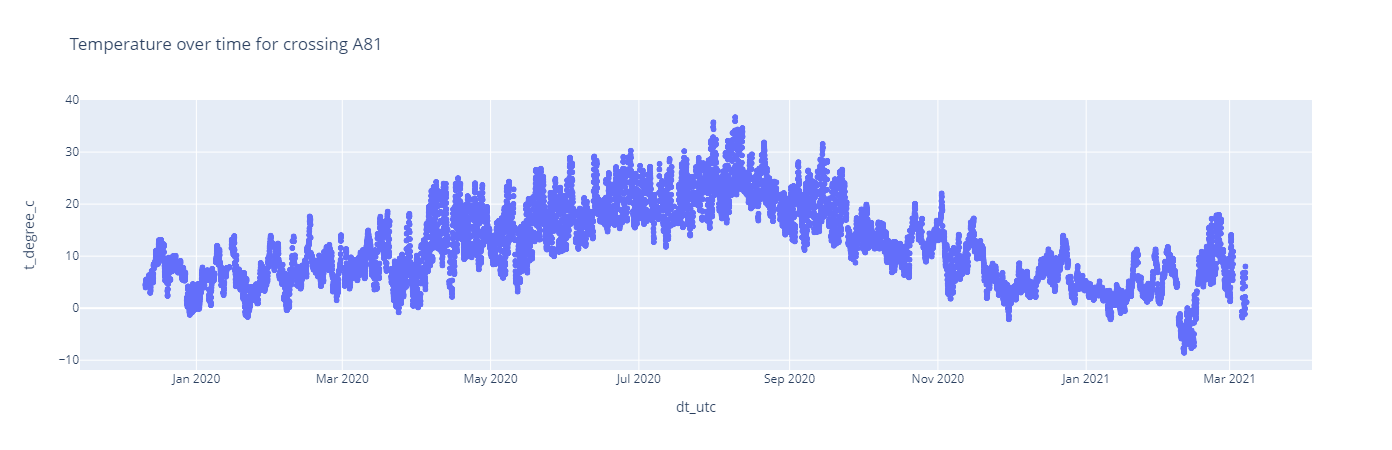

In [59]:
fig = px.scatter(df_train_sensor_id_16, x="dt_utc", y="t_degree_c", title="Temperature over time for crossing A7")
fig.show()
fig = px.scatter(df_train_sensor_id_20, x="dt_utc", y="t_degree_c", title="Temperature over time for crossing A81")
fig.show()

## 12. Traffic situation throughout the year

We can see that at the beginning of july and november of 2020 the average traffic sensor values of all traffic sensors are constantly zero for crossing A81. this means that the sensor did not record any traffic during the time. This is something important to consider for model building. A similar phenomenon can be seen for crossing A7. Here the sensors did not record any data at the end of may and at the beginning of november 2020. We can also see that the no2 values are not really influenced by those extreme values. This is another indicator that the traffic values at the mentioned times are strictly not viable.

In [60]:
"""
- AXX_DXX_Z Stündlich gemittelte Anzahl
der an Kreuzung AXX durch
Verkehrssensor DXX
detektiereten Fahrzeuge pro
Minute

– AXX_DXX_B Prozentualer zeitlicher Anteil
zu dem an Kreuzung AXX
durch Verkehrssensor DXX
Fahrzeuge detektiert wurden
"""
# SENSOR_ID = 20 --> Kreuzung = A81

# SUM of all A81 DXX Z Sensors
df_train_sensor_id_20["SUM_A81_DXX_Z"] = df_train_sensor_id_20[['A81_D31_Z','A81_D32_Z', "A81_D33_Z", 
                                                                "A81_D34_Z", "A81_D41_Z", "A81_D42_Z", 
                                                                "A81_D43_Z", "A81_D44_Z", "A81_D30_Z"]].sum(axis = 1)

In [61]:
# SUM of all A7 DXX Z Sensors
df_train_sensor_id_16["SUM_A7_DXX_Z"] = df_train_sensor_id_16[["A7_D21_Z", "A7_D22_Z", "A7_D41_Z", "A7_D42_Z"]].sum(axis = 1)

In [80]:
# Traffic situation thorugh out the year -> group by date
df_train_sensor_id_16_group_by_date = df_train_sensor_id_16.groupby(["date"]).mean()
df_train_sensor_id_20_group_by_date = df_train_sensor_id_20.groupby(["date"]).mean()

df_train_sensor_id_16_group_by_date.drop(df_train_sensor_id_16_group_by_date.tail(8).index,inplace=True) # drop last n rows
df_train_sensor_id_20_group_by_date.drop(df_train_sensor_id_20_group_by_date.tail(8).index,inplace=True) # drop last n rows

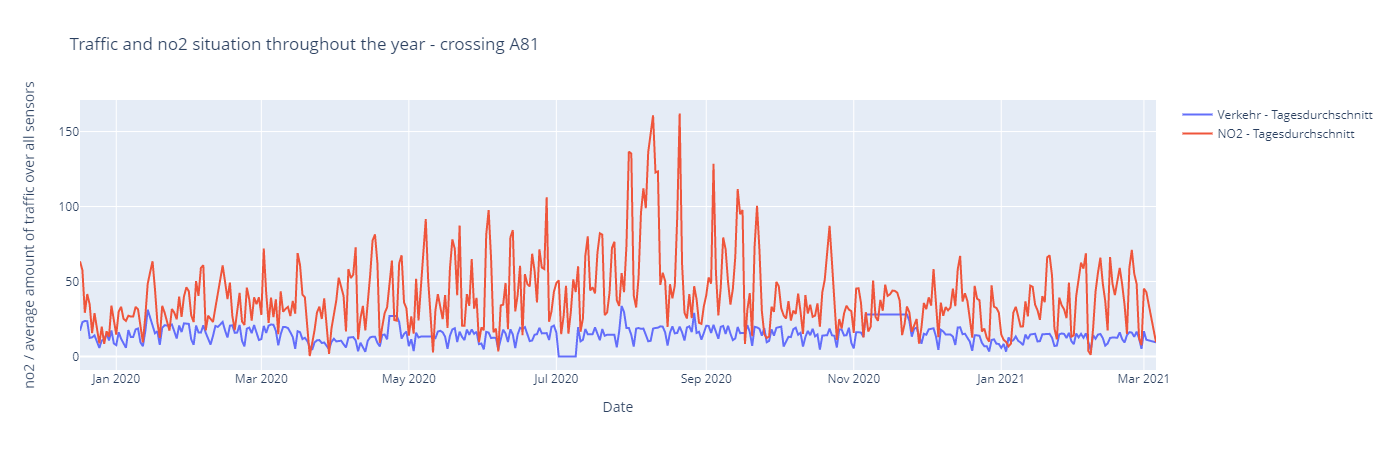

In [81]:
fig = go.Figure(layout=dict(title=dict(text="Traffic and no2 situation throughout the year - crossing A81",)))
fig.add_trace(go.Scatter(x=df_train_sensor_id_20_group_by_date.index, y=df_train_sensor_id_20_group_by_date["SUM_A81_DXX_Z"],
                    mode='lines',
                    name='Verkehr - Tagesdurchschnitt'))
fig.add_trace(go.Scatter(x=df_train_sensor_id_20_group_by_date.index, y=df_train_sensor_id_20_group_by_date["no2"],
                    mode='lines',
                    name='NO2 - Tagesdurchschnitt'))
fig.update_layout( xaxis_title="Date",
    yaxis_title="no2 / average amount of traffic over all sensors")
fig.show()

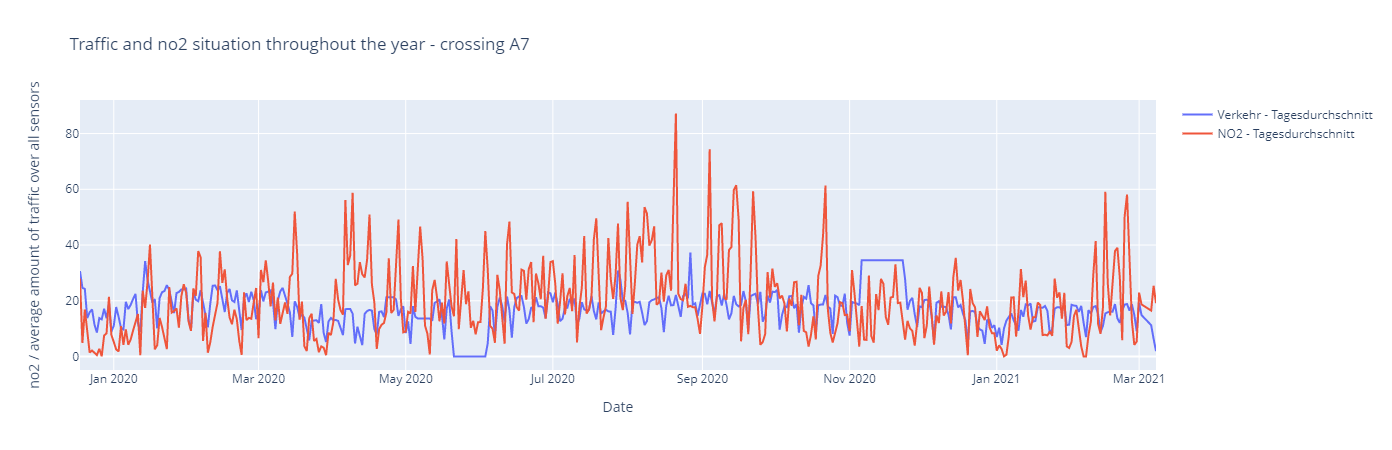

In [83]:
fig = go.Figure(layout=dict(title=dict(text="Traffic and no2 situation throughout the year - crossing A7",)))
fig.add_trace(go.Scatter(x=df_train_sensor_id_16_group_by_date.index, y=df_train_sensor_id_16_group_by_date["SUM_A7_DXX_Z"],
                    mode='lines',
                    name='Verkehr - Tagesdurchschnitt'))
fig.add_trace(go.Scatter(x=df_train_sensor_id_16_group_by_date.index, y=df_train_sensor_id_16_group_by_date["no2"],
                    mode='lines',
                    name='NO2 - Tagesdurchschnitt'))
fig.update_layout( xaxis_title="Date",
    yaxis_title="no2 / average amount of traffic over all sensors")
fig.show()

### Traffic Situation for each hour of the day throughout the year
In the following two plots we can see the traffic situation throughout the year for each hour. For both crossing we can see the same problem as mentioned earlier that the traffis sensor did not record the traffic properly at the beginning of november. Furthermore we can see that the highest traffic amount on a given day for crossing A7 is measured in the early hours around 7am but for crossing A81 the highest traffic happens at around 5-6pm. We can also see a general drastic decrease in traffic overall at the end of march which happend due to the first corna lockdown.

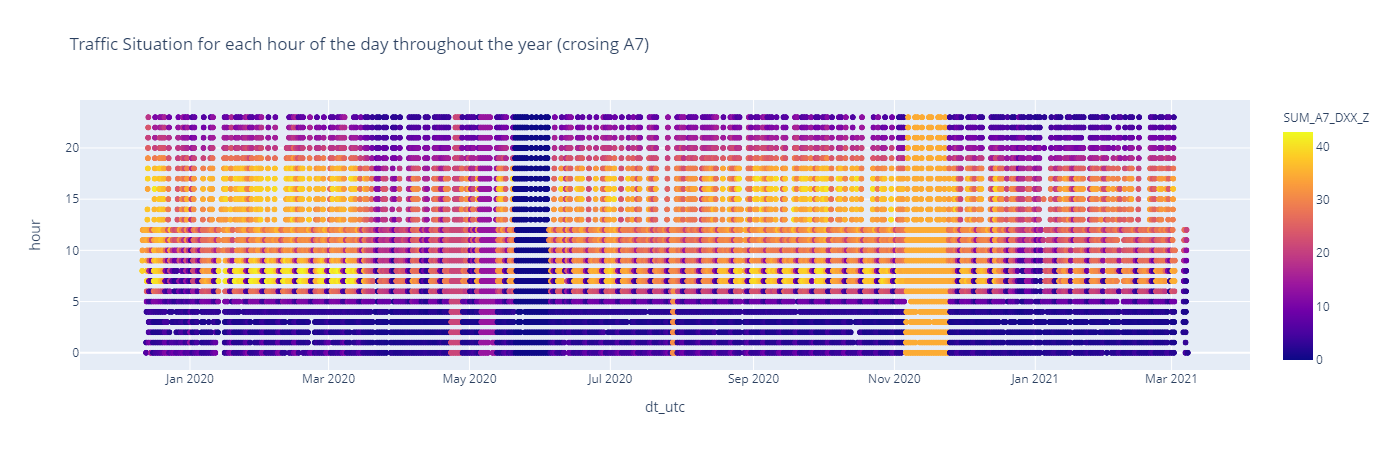

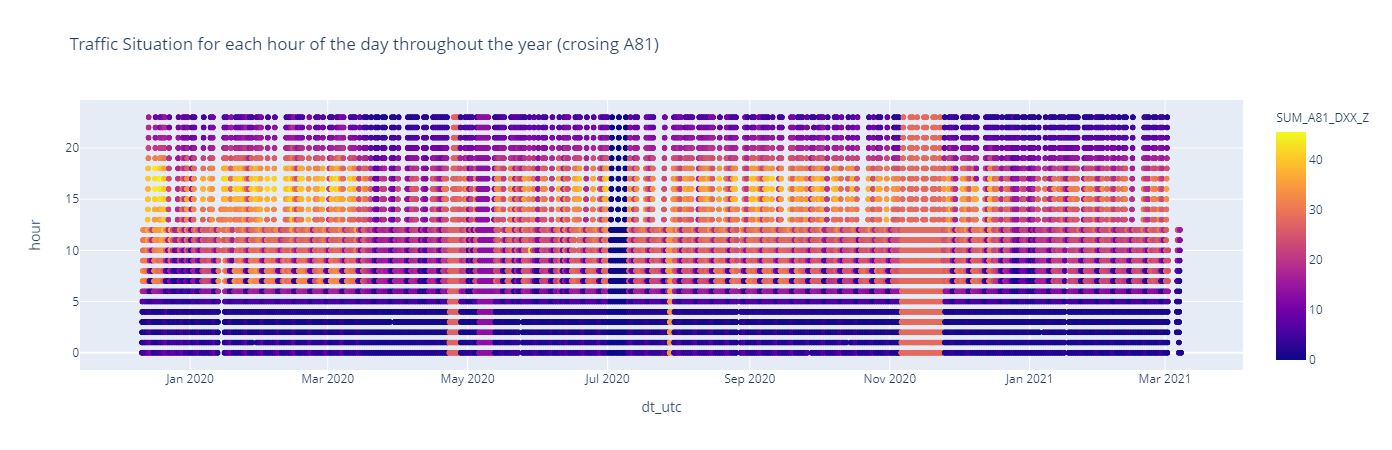

In [84]:
fig = px.scatter(df_train_sensor_id_16, x="dt_utc", y="hour", color="SUM_A7_DXX_Z", title="Traffic Situation for each hour of the day throughout the year (crosing A7)")
fig.show()
fig = px.scatter(df_train_sensor_id_20, x="dt_utc", y="hour", color="SUM_A81_DXX_Z", title="Traffic Situation for each hour of the day throughout the year (crosing A81)")
fig.show()

## 13. No2 values and humidity
Humidity and no2 values show a clear negative correlation. The higher the humidity is the lower are the no2 values. Therefore during summer we have higher no2 values because the humidity is lower on average.

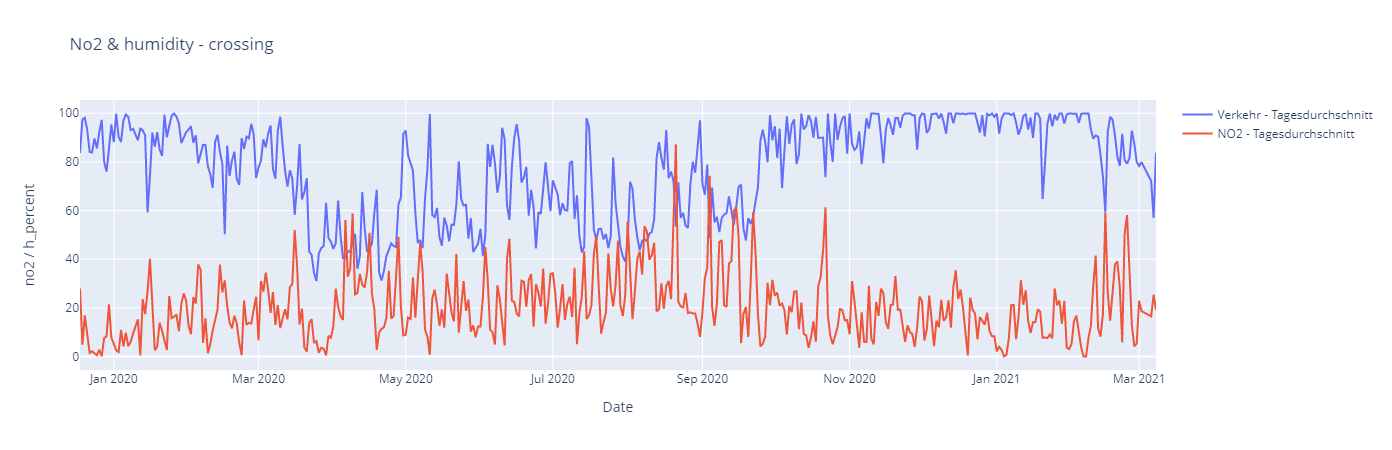

In [87]:
fig = go.Figure(layout=dict(title=dict(text="No2 & humidity - crossing ",)))
fig.add_trace(go.Scatter(x=df_train_sensor_id_16_group_by_date.index, y=df_train_sensor_id_16_group_by_date["h_percent"],
                    mode='lines',
                    name='Verkehr - Tagesdurchschnitt'))
fig.add_trace(go.Scatter(x=df_train_sensor_id_16_group_by_date.index, y=df_train_sensor_id_16_group_by_date["no2"],
                    mode='lines',
                    name='NO2 - Tagesdurchschnitt'))
fig.update_layout( xaxis_title="Date",
    yaxis_title="no2 / h_percent")
fig.show()

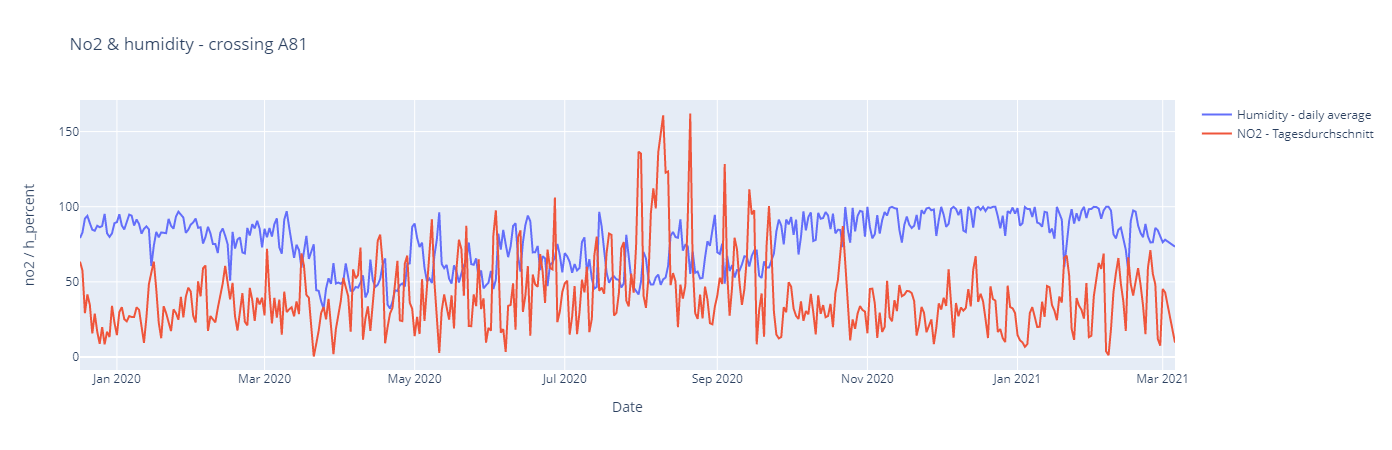

In [89]:
fig = go.Figure(layout=dict(title=dict(text="No2 & humidity - crossing A81",)))
fig.add_trace(go.Scatter(x=df_train_sensor_id_20_group_by_date.index, y=df_train_sensor_id_20_group_by_date["h_percent"],
                    mode='lines',
                    name='Humidity - daily average'))
fig.add_trace(go.Scatter(x=df_train_sensor_id_20_group_by_date.index, y=df_train_sensor_id_20_group_by_date["no2"],
                    mode='lines',
                    name='NO2 - Tagesdurchschnitt'))
fig.update_layout( xaxis_title="Date",
    yaxis_title="no2 / h_percent")
fig.show()